Warp 1.11.0 initialized:
   CUDA Toolkit 12.9, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 5090" (31 GiB, sm_120, mempool enabled)
   Kernel cache:
     /home/christian/.cache/warp/1.11.0


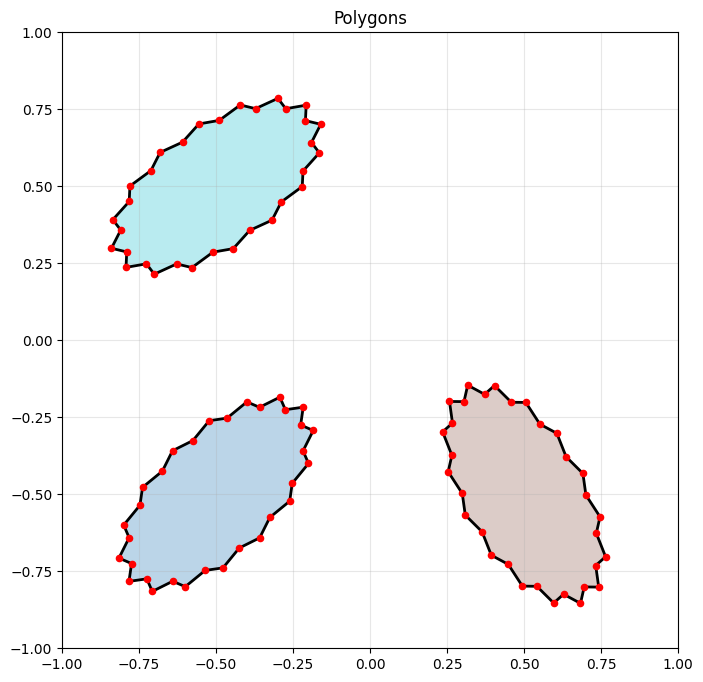

In [1]:
from neural_spline.types import ConvexPolytope, PCAComponent
from neural_spline.polygons import generate_polygons
from neural_spline.vis import plot_polygons
import numpy as np

polygons = generate_polygons('3x16', convex=False, stretch=(1, 0.5), 
                             star_ratio=0.9, rotation=[np.pi/4, -np.pi/3, np.pi/5])

plot_polygons(polygons)

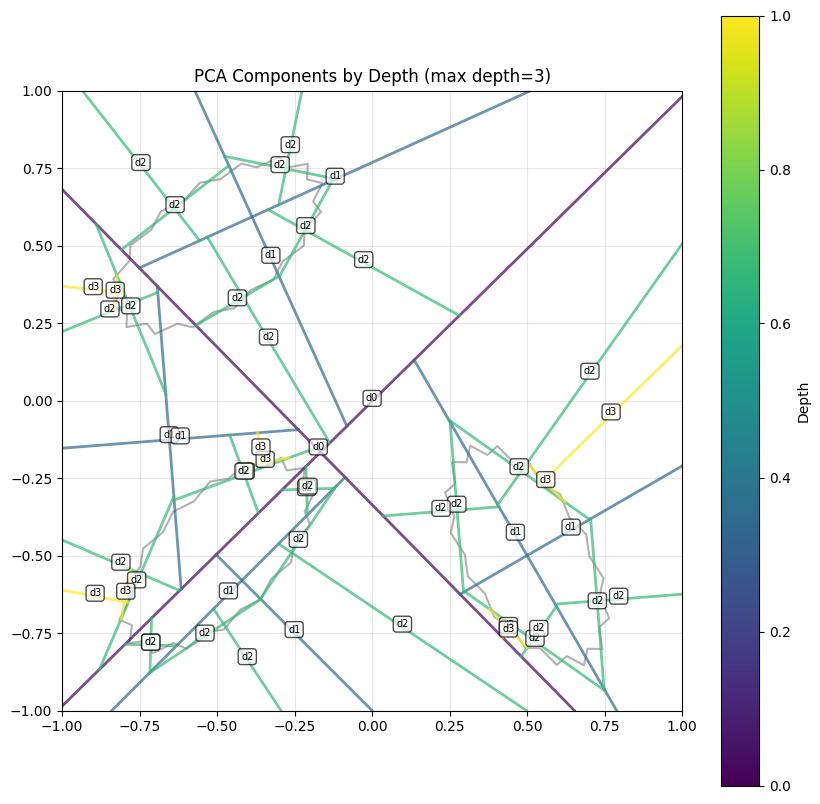

In [2]:
from neural_spline.geometry import constrained_recursive_pca, flatten_pca_tree
import torch
import matplotlib.pyplot as plt

def plot_pca_by_depth(polygons, node, figsize=(10, 10)):
    """Plot PCA components colored by recursion depth."""
    plt.figure(figsize=figsize)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Plot polygons
    for polygon in polygons:
        closed_poly = np.vstack([polygon, polygon[0:1]])
        plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=1.5, alpha=0.3)
    
    # Get components and max depth
    components = flatten_pca_tree(node)
    max_depth = max(c.depth for c in components)
    
    # Plot components colored by depth
    for comp in components:
        start = comp.start.cpu().numpy()
        end = comp.end.cpu().numpy()
        
        # Color by depth (deeper = more purple)
        color = plt.cm.viridis(comp.depth / max_depth)
        
        plt.plot([start[0], end[0]], [start[1], end[1]], 
                color=color, linewidth=2, alpha=0.7)
        
        # Add depth annotation at midpoint
        mid = (start + end) / 2
        plt.text(mid[0], mid[1], f'd{comp.depth}', 
                fontsize=7, ha='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    plt.title(f'PCA Components by Depth (max depth={max_depth})')
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), 
                label='Depth', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    plt.show()

vertices = np.concatenate(polygons, axis=0)
vertices = torch.from_numpy(vertices).float()
node = constrained_recursive_pca(vertices, max_depth=100)

plot_pca_by_depth(polygons, node)

In [3]:
from pytorch3d.io import load_ply
import plotly.graph_objects as go

def plot_pca_plotly(mesh_vertices, mesh_faces, node):
    """Plotly with FULL free rotation (not locked to Z-axis)."""
    if isinstance(mesh_vertices, torch.Tensor):
        mesh_vertices = mesh_vertices.cpu().numpy()
    if isinstance(mesh_faces, torch.Tensor):
        mesh_faces = mesh_faces.cpu().numpy()
    
    components = flatten_pca_tree(node)
    max_depth = max(c.depth for c in components) if components else 1
    
    fig = go.Figure()
    
    # Mesh
    fig.add_trace(go.Mesh3d(
        x=mesh_vertices[:, 0],
        y=mesh_vertices[:, 1],
        z=mesh_vertices[:, 2],
        i=mesh_faces[:, 0],
        j=mesh_faces[:, 1],
        k=mesh_faces[:, 2],
        opacity=0.3,
        color='lightgray',
        flatshading=True
    ))
    
    # PCA components
    for comp in components:
        start = comp.start.cpu().numpy()
        end = comp.end.cpu().numpy()
        
        color_val = comp.depth / max_depth
        color_rgb = plt.cm.viridis(color_val)[:3]
        color_str = f'rgb({int(color_rgb[0]*255)}, {int(color_rgb[1]*255)}, {int(color_rgb[2]*255)})'
        
        fig.add_trace(go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode='lines+markers',
            line=dict(width=6, color=color_str),
            marker=dict(size=5),
            showlegend=False,
            hovertext=f"{comp.label}<br>Depth: {comp.depth}"
        ))
    
    fig.update_layout(
        width=800,   # Square aspect
        height=800,
        scene=dict(
            aspectmode='cube',  # Force cube aspect ratio
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
            camera=dict(
                center=dict(x=0, y=0, z=0),
                up=dict(x=0, y=0, z=1)
            ),
            dragmode='orbit'
        )
    )
    # Enable scrollZoom for better control
    fig.show(config={
        'scrollZoom': True,
        'displayModeBar': True,
        'displaylogo': False
    })
    
    # return fig
mesh_path = 'data/meshes/Armadillo.ply'
verts, faces = load_ply(mesh_path)
# Normalize mesh to [-1, 1] with padding (keep as tensor)
padding = 0.1
centroid = verts.mean(dim=0)
verts = verts - centroid

# Compute extents
min_coords = verts.min(dim=0)[0]
max_coords = verts.max(dim=0)[0]
extents = max_coords - min_coords
max_extent = extents.max().item()

if max_extent > 0:
    scale = 2.0 * (1.0 - padding) / max_extent
    verts = verts * scale

node = constrained_recursive_pca(verts, max_depth=3, min_points=50)

plot_pca_plotly(verts, faces, node)

Also the first issues arises for 3d with large small min_points or large max_depth this is very slow, potentially a bottle neck 